# Token Healing

Experimental method for sampling a tokenization that is consistent with an observed string.

In [1]:
import nest_asyncio

nest_asyncio.apply()

In [2]:
import numpy as np
import pylab as pl
from collections import defaultdict

from genparse import Float
from genparse.trace1 import TraceSWOR, log_zero
from genparse.util import set_seed, load_model_by_name
from notes.token_healing import PromptParticle, p_next_healing

from arsenal import colors
from arsenal.maths import sample_dict, logsumexp, compare

WARNING 08-01 15:49:28 _custom_ops.py:14] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')


In [3]:
set_seed(1234)

# lm = load_model_by_name('mock-gpt2')
# lm = load_model_by_name('gpt2', temperature=0.12)
lm = load_model_by_name('gpt2')

prompt = ' Sequential Monte Carlo is g'

In [4]:
# x = 'To be, or not to be, that'
# x = ' To be, or not, that is'

In [5]:
# lm.tokenizer.decode(lm._model.model.generate(lm.tokenizer.encode(x, return_tensors='pt'), max_new_tokens=10).squeeze().tolist())

In [6]:
# lm.tokenizer.decode(lm._model.model.generate(lm.tokenizer.encode(x + ' ', return_tensors='pt'), max_new_tokens=10).squeeze().tolist())

In [7]:
def logprefix(self, context):
    return sum(self.logp_next(context[:i])[y] for i, y in enumerate(context))

In [8]:
tracer = TraceSWOR()

data = []

T = 0
while np.exp(tracer.root.log_mass) > 1e-20:
    T += 1
    if T > 20:
        break
    with tracer:
        particle = PromptParticle(lm, prompt, draw=tracer)
        log_mass = tracer.cur.log_mass  # must do in the with-statement!

    print(
        f'{tracer.root.log_mass}\t',
        particle,
        #        + colors.light.cyan % '['
        #        + (colors.light.cyan % '|').join(repr(y)[1:-1] for y in particle.context)
        #        + colors.light.cyan % ']'
    )

    data.append(
        {
            'context': particle.context,
            'logP': particle.logP,
            'logW': particle.logW,
            'logQ': particle.logQ,
            'logprefix': logprefix(lm, particle.context),
            'log_mass': log_mass,
        }
    )

print(f'truncated with {tracer.root.log_mass:g} log mass left')

-0.0005059650679887784	 -91.95342823401838:	[ |Sequ|ential| M|on|t|e| C|ar|lo| is| going]
-0.0005067392860368947	 -110.95862230390762:	[ S|e|q|u|en|t|ia|l| M|ont|e| C|ar|lo| is| gre]
-0.0005159586021317719	 -107.2758243389484:	[ |Sequ|ential| M|on|t|e| C|a|rl|o| is| gaining]
-0.0005167475532670274	 -172.75399245172628:	[ |S|e|q|u|en|t|ia|l| |M|on|t|e| C|a|rl|o| |i|s| |ga]
-0.0005167485712898046	 -153.68276004417604:	[ |S|e|que|n|t|ial| M|on|t|e| C|a|r|l|o| |is| grim]
-0.004574306200010869	 -92.64287042407685:	[ |Sequ|ential| M|ont|e| C|a|r|lo| is| going]
-0.004575517211064917	 -114.12608985744812:	[ |Sequ|ential| |M|ont|e| C|a|rl|o| |is| |guard]
-0.004575597715277213	 -82.83264685930166:	[ |Se|q|ue|nt|i|al| |Mon|te| Carlo| is| gr]
-0.00457858581222359	 -125.1565557075182:	[ |Sequ|ential| M|on|t|e| |C|arl|o| |i|s| |ges]
-0.004578623682033656	 -132.38055151727787:	[ |S|equ|ent|ia|l| M|ont|e| C|a|rl|o| |i|s| ge]
-0.004838774131207257	 -68.23426786528357:	[ S|equ|en|t|ia|l| Monte| Carlo| i

In [9]:
import pandas as pd

df = pd.DataFrame(data)

In [10]:
df

,context,logP,logW,logQ,logprefix,log_mass
0,"( , Sequ, ential, M, on, t, e, C, ar, lo, i...",-99.542724,-91.953428,-7.589296,-99.542724,-7.589296
1,"( S, e, q, u, en, t, ia, l, M, ont, e, C, ar...",-125.030541,-110.958622,-14.071919,-125.030541,-14.071919
2,"( , Sequ, ential, M, on, t, e, C, a, rl, o, ...",-118.870545,-107.275824,-11.594721,-118.870545,-11.594721
3,"( , S, e, q, u, en, t, ia, l, , M, on, t, e, ...",-186.807070,-172.753992,-14.053078,-186.807070,-14.053078
4,"( , S, e, que, n, t, ial, M, on, t, e, C, a,...",-174.388680,-153.682760,-20.705920,-174.388680,-20.705920
5,"( , Sequ, ential, M, ont, e, C, a, r, lo, i...",-98.152589,-92.642870,-5.509719,-98.152589,-5.509719
6,"( , Sequ, ential, , M, ont, e, C, a, rl, o, ...",-127.754720,-114.126090,-13.628630,-127.754720,-13.628630
7,"( , Se, q, ue, nt, i, al, , Mon, te, Carlo, ...",-99.172179,-82.832647,-16.339532,-99.172179,-16.339532
8,"( , Sequ, ential, M, on, t, e, , C, arl, o, ...",-137.882007,-125.156556,-12.725451,-137.882007,-12.725451
9,"( , S, equ, ent, ia, l, M, ont, e, C, a, rl,...",-149.474242,-132.380552,-17.093690,-149.474242,-17.093690


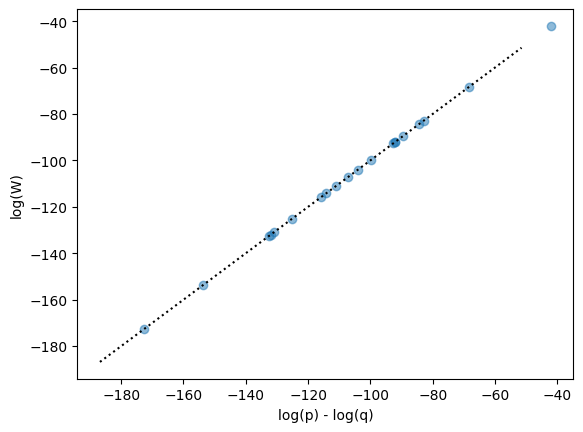

In [11]:
pl.scatter(df.logP - df.logQ, df.logW, alpha=0.5)
a = min(df.logP)
b = max(df.logP)
pl.xlabel('log(p) - log(q)')
pl.ylabel('log(W)')
pl.plot([a, b], [a, b], linestyle=':', c='k');

In [12]:
assert np.allclose(df.log_mass, df.logQ)

We quickly check that the target distrbution $p$ used in the particle's weight computation is equal to the prefix probability.

In [13]:
compare(
    df.logprefix,
    df.logP,
);  # .show();


Comparison: n=20
  norms: [549.891, 549.891]
  pearson: 1
  spearman: 1
  ℓ∞: 0
  ℓ₂: 0
  same-sign: 100.00% (20/20)
  regression: [1.000 -0.000] R=0.000



The proposal distribution over prompts is not well-correlated with the prefix probability of the token string.


Comparison: n=20
  norms: [549.891, 56.048]
  pearson: 0.57035
  spearman: 0.583459
  ℓ∞: 172.754
  ℓ₂: 496.23
  same-sign: 100.00% (20/20)
  regression: [4.324 -67.758] R=113.864
  have is larger: 100.0% (20/20)



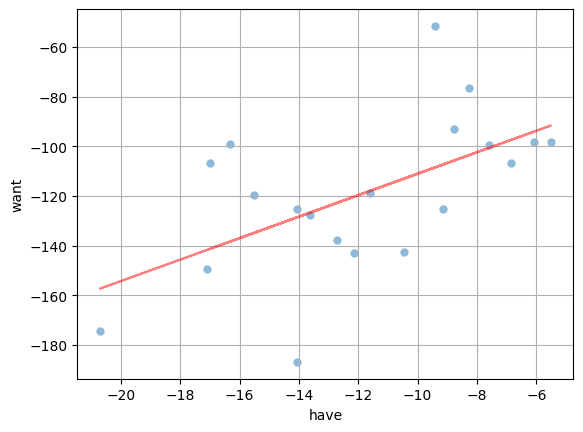

In [14]:
compare(
    df.logprefix,
    df.logQ,
).show();

However, the importance weight distribution is (we are using $p(x) = \frac{p(x)}{q(x)} q(x) = w(x) q(x)$ here since we are enumerating $x$ rather than sampling it.)

In [15]:
compare(
    df.logprefix,
    df.logQ + df.logW,
);  # .show();


Comparison: n=20
  norms: [549.891, 549.891]
  pearson: 1
  spearman: 1
  ℓ∞: 2.84217e-14
  ℓ₂: 5.85929e-14
  same-sign: 100.00% (20/20)
  regression: [1.000 -0.000] R=0.000



In [16]:
df.sort_values('logW', ascending=False)

,context,logP,logW,logQ,logprefix,log_mass
11,"( , Sequ, ential, Monte, Carlo, is, generic)",-51.466095,-42.059929,-9.406166,-51.466095,-9.406166
10,"( S, equ, en, t, ia, l, Monte, Carlo, is, ...",-76.493227,-68.234268,-8.258959,-76.493227,-8.258959
7,"( , Se, q, ue, nt, i, al, , Mon, te, Carlo, ...",-99.172179,-82.832647,-16.339532,-99.172179,-16.339532
15,"( , Sequ, ential, M, on, te, Ca, r, lo, is,...",-93.155691,-84.373430,-8.782261,-93.155691,-8.782261
12,"( S, e, qu, en, t, ial, M, on, te, Car, lo, ...",-106.507607,-89.501809,-17.005798,-106.507607,-17.005798
0,"( , Sequ, ential, M, on, t, e, C, ar, lo, i...",-99.542724,-91.953428,-7.589296,-99.542724,-7.589296
18,"( , Sequ, ential, M, on, te, C, a, r, lo, i...",-98.263597,-92.200817,-6.062780,-98.263597,-6.062780
5,"( , Sequ, ential, M, ont, e, C, a, r, lo, i...",-98.152589,-92.642870,-5.509719,-98.152589,-5.509719
17,"( , Sequ, ential, , M, on, t, e, , Car, lo, ...",-106.608520,-99.756055,-6.852464,-106.608520,-6.852464
14,"( Se, que, nt, ial, M, on, t, e, C, a, r, lo...",-119.484940,-103.975052,-15.509888,-119.484940,-15.509888


In [17]:
prompt

' Sequential Monte Carlo is g'

In [18]:
p_next_healing(lm, prompt).sort_descending()

key,value
great,0.27434479971927267
going,0.1360283016161375
good,0.11283510815862914
generally,0.10554042736339561
getting,0.07730107129471153
general,0.0323504809383364
gaining,0.030363813729365297
given,0.02417030964433939
giving,0.021667118126136392
growing,0.013486097414666408


In [19]:
df['canonicalized'] = (
    df.context.map(''.join)
    .map(lm.tokenizer.encode)
    .map(lambda context: tuple(lm._decode[y] for y in context))
    .map('|'.join)
)

In [20]:
df['logprefix_canonicalized'] = (
    df.context.map(''.join)
    .map(lm.encode_prompt)
    .map(lambda context: logprefix(lm, context))
)

In [21]:
df

,context,logP,logW,logQ,logprefix,log_mass,canonicalized,logprefix_canonicalized
0,"( , Sequ, ential, M, on, t, e, C, ar, lo, i...",-99.542724,-91.953428,-7.589296,-99.542724,-7.589296,Sequ|ential| Monte| Carlo| is| going,-40.030303
1,"( S, e, q, u, en, t, ia, l, M, ont, e, C, ar...",-125.030541,-110.958622,-14.071919,-125.030541,-14.071919,Sequ|ential| Monte| Carlo| is| gre,-47.610931
2,"( , Sequ, ential, M, on, t, e, C, a, rl, o, ...",-118.870545,-107.275824,-11.594721,-118.870545,-11.594721,Sequ|ential| Monte| Carlo| is| gaining,-41.529914
3,"( , S, e, q, u, en, t, ia, l, , M, on, t, e, ...",-186.807070,-172.753992,-14.053078,-186.807070,-14.053078,Sequ|ential| Monte| Carlo| is| ga,-49.529525
4,"( , S, e, que, n, t, ial, M, on, t, e, C, a,...",-174.388680,-153.682760,-20.705920,-174.388680,-20.705920,Sequ|ential| Monte| Carlo| is| grim,-48.101669
5,"( , Sequ, ential, M, ont, e, C, a, r, lo, i...",-98.152589,-92.642870,-5.509719,-98.152589,-5.509719,Sequ|ential| Monte| Carlo| is| going,-40.030303
6,"( , Sequ, ential, , M, ont, e, C, a, rl, o, ...",-127.754720,-114.126090,-13.628630,-127.754720,-13.628630,Sequ|ential| Monte| Carlo| is| guard,-50.287856
7,"( , Se, q, ue, nt, i, al, , Mon, te, Carlo, ...",-99.172179,-82.832647,-16.339532,-99.172179,-16.339532,Sequ|ential| Monte| Carlo| is| gr,-46.014266
8,"( , Sequ, ential, M, on, t, e, , C, arl, o, ...",-137.882007,-125.156556,-12.725451,-137.882007,-12.725451,Sequ|ential| Monte| Carlo| is| g|es,-51.145161
9,"( , S, equ, ent, ia, l, M, ont, e, C, a, rl,...",-149.474242,-132.380552,-17.093690,-149.474242,-17.093690,Sequ|ential| Monte| Carlo| is| ge,-45.738639


Canonicalizing the sampled token sequence appears to increase its probability in all cases.  [Note, however, that this is not necessarily true.  I have seen cases where the sampled, noncanonical sequence has higher probability.]

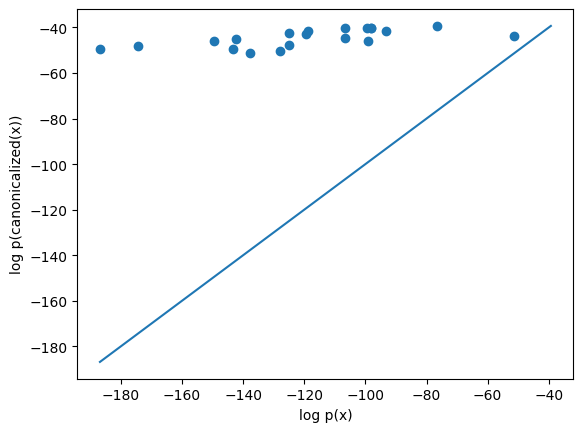

In [22]:
pl.scatter(df.logprefix, df.logprefix_canonicalized)
a = min(df.logprefix.min(), df.logprefix_canonicalized.min())
b = max(df.logprefix.max(), df.logprefix_canonicalized.max())
pl.plot([a, b], [a, b])
pl.ylabel('log p(canonicalized(x))')
pl.xlabel('log p(x)');

In [23]:
assert np.all(df.logprefix_canonicalized >= df.logprefix)

In [24]:
from genparse.util import lark_guide

In [25]:
from genparse.proposal.crunch import Crunching

In [26]:
guide = lark_guide('start: / ?Sequential Monte Carlo is g[a-zA-Z]*/')

In [27]:
crunch = Crunching(guide=guide, llm=lm)

In [32]:
for t, x in enumerate(
    crunch.posterior_enumerate(prompt=(), beam_width=10, max_generations=1)
):
    print(x)
    break

Output()

Item(ps=5.19733193958635e-20, xs=('Sequ', 'ential', ' Monte', ' Carlo', ' is', ' good', '▪'), ys=('Sequ', 'ential',
' Monte', ' Carlo', ' is', ' good', '<|endoftext|>'))

In [33]:
np.log(x.ps)

-44.403556454509584

In [34]:
df.logP.max()

-51.46609527617693

In [50]:
from genparse.steer import Sampler
from genparse.proposal import CharacterProposal, TokenProposal

sampler = Sampler(llm=lm, guide=guide)
# proposal = CharacterProposal(llm=llm, guide=guide, **proposal_opts)
proposal = TokenProposal(llm=lm, guide=guide, K=10)

In [51]:
particles = sampler.run_inference(
    prompt=(),
    proposal=proposal,
    method='smc-standard',
    max_tokens=25,
    n_particles=10,
    return_record=True,
)

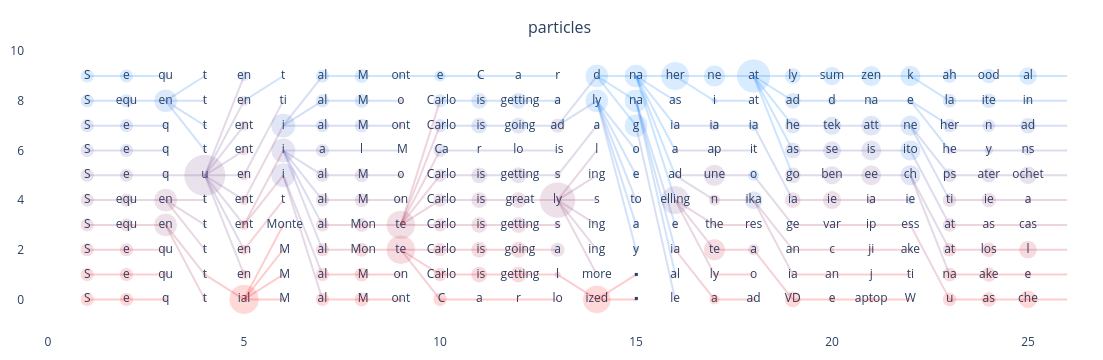

In [52]:
particles.record.plotly()

In [53]:
particles

key,value
Sequential Monte Carlo is goingaddnaherneatlysumzenkahoodal,0.17257832079474364
Sequential Monte Carlo is goingaddnaherneathetekattnepsaterochet,0.17257831435901239
Sequential Monte Carlo is goingaddnaherneatgobeneechatlosl,0.17257831122443693
Sequential Monte Carlo is goingaddnaaduneogevaripessuasche,0.17257829063946348
Sequential Monte Carlo is goingaddnaherneataddnaehernad,0.13717580999358336
Sequential Monte Carlo is goingaddnaherneataddnaeheyns,0.06359962312330929
Sequential Monte Carlo is goingaddnaherneatgobeneechnaakee,0.03131136709002462
Sequential Monte Carlo is goingaddnaherneathetekattnetiiea,0.027003297373667627
Sequential Monte Carlo is goingaddnaherneatlysumzenklaitein,0.0265826013619443
Sequential Monte Carlo is goingaddnaherneatasseisitoatascas,0.0240140640398144


In [39]:
np.exp(particles.log_total), particles.ess

(3.544724092517962e-37, 9.000000022807397)

In [40]:
particles1 = sampler.run_inference(
    prompt=(),
    proposal=proposal,
    ess_threshold=0,
    method='smc-standard',
    max_tokens=25,
    n_particles=10,
    return_record=True,
)

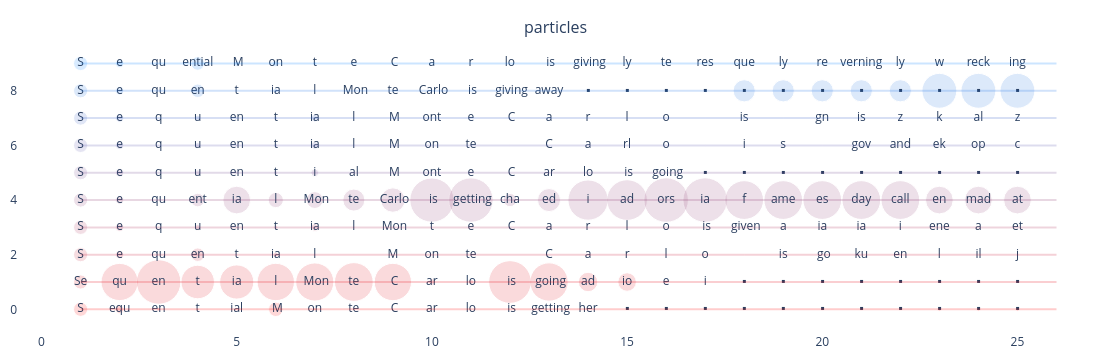

In [41]:
particles1.record.plotly()

In [42]:
particles1

key,value
Sequential Monte Carlo is givingaway▪,0.6081231399862541
Sequential Monte Carlo is gettingchaediadorsiafameesdaycallenmadat,0.3838161350347057
Sequential Monte Carlo is gettingher▪,0.007391975887611244
Sequential Monte Carlo is goingadioei▪,0.0006687242482526433
Sequential Monte Carlo is going▪,2.4843176203346842e-08
Sequential Monte Carlo is givinglyteresquelyreverninglywrecking,7.915226427097285e-17
Sequential Monte Carlo is givenaiaiaieneaet,4.501962397303354e-23
Sequential Monte Carlo is gniszkalz,3.685125997164123e-24
Sequential Monte Carlo is govandekopc,2.1221163346312034e-26
Sequential Monte Carlo is gokuenlilj,3.839833091909587e-27


In [43]:
np.exp(particles1.log_total), particles1.ess

(2.8565378013803314e-42, 1.9335490717030286)

In [44]:
from arsenal.profiling import profiler, prof_to_graphviz

In [45]:
lm.clear_cache()
with profiler():
    sampler.run_inference(
        prompt=(),
        proposal=proposal,
        method='smc-standard',
        max_tokens=25,
        n_particles=10,
        return_record=True,
    )

wrote: out.prof (use `gprof-viz` to view)


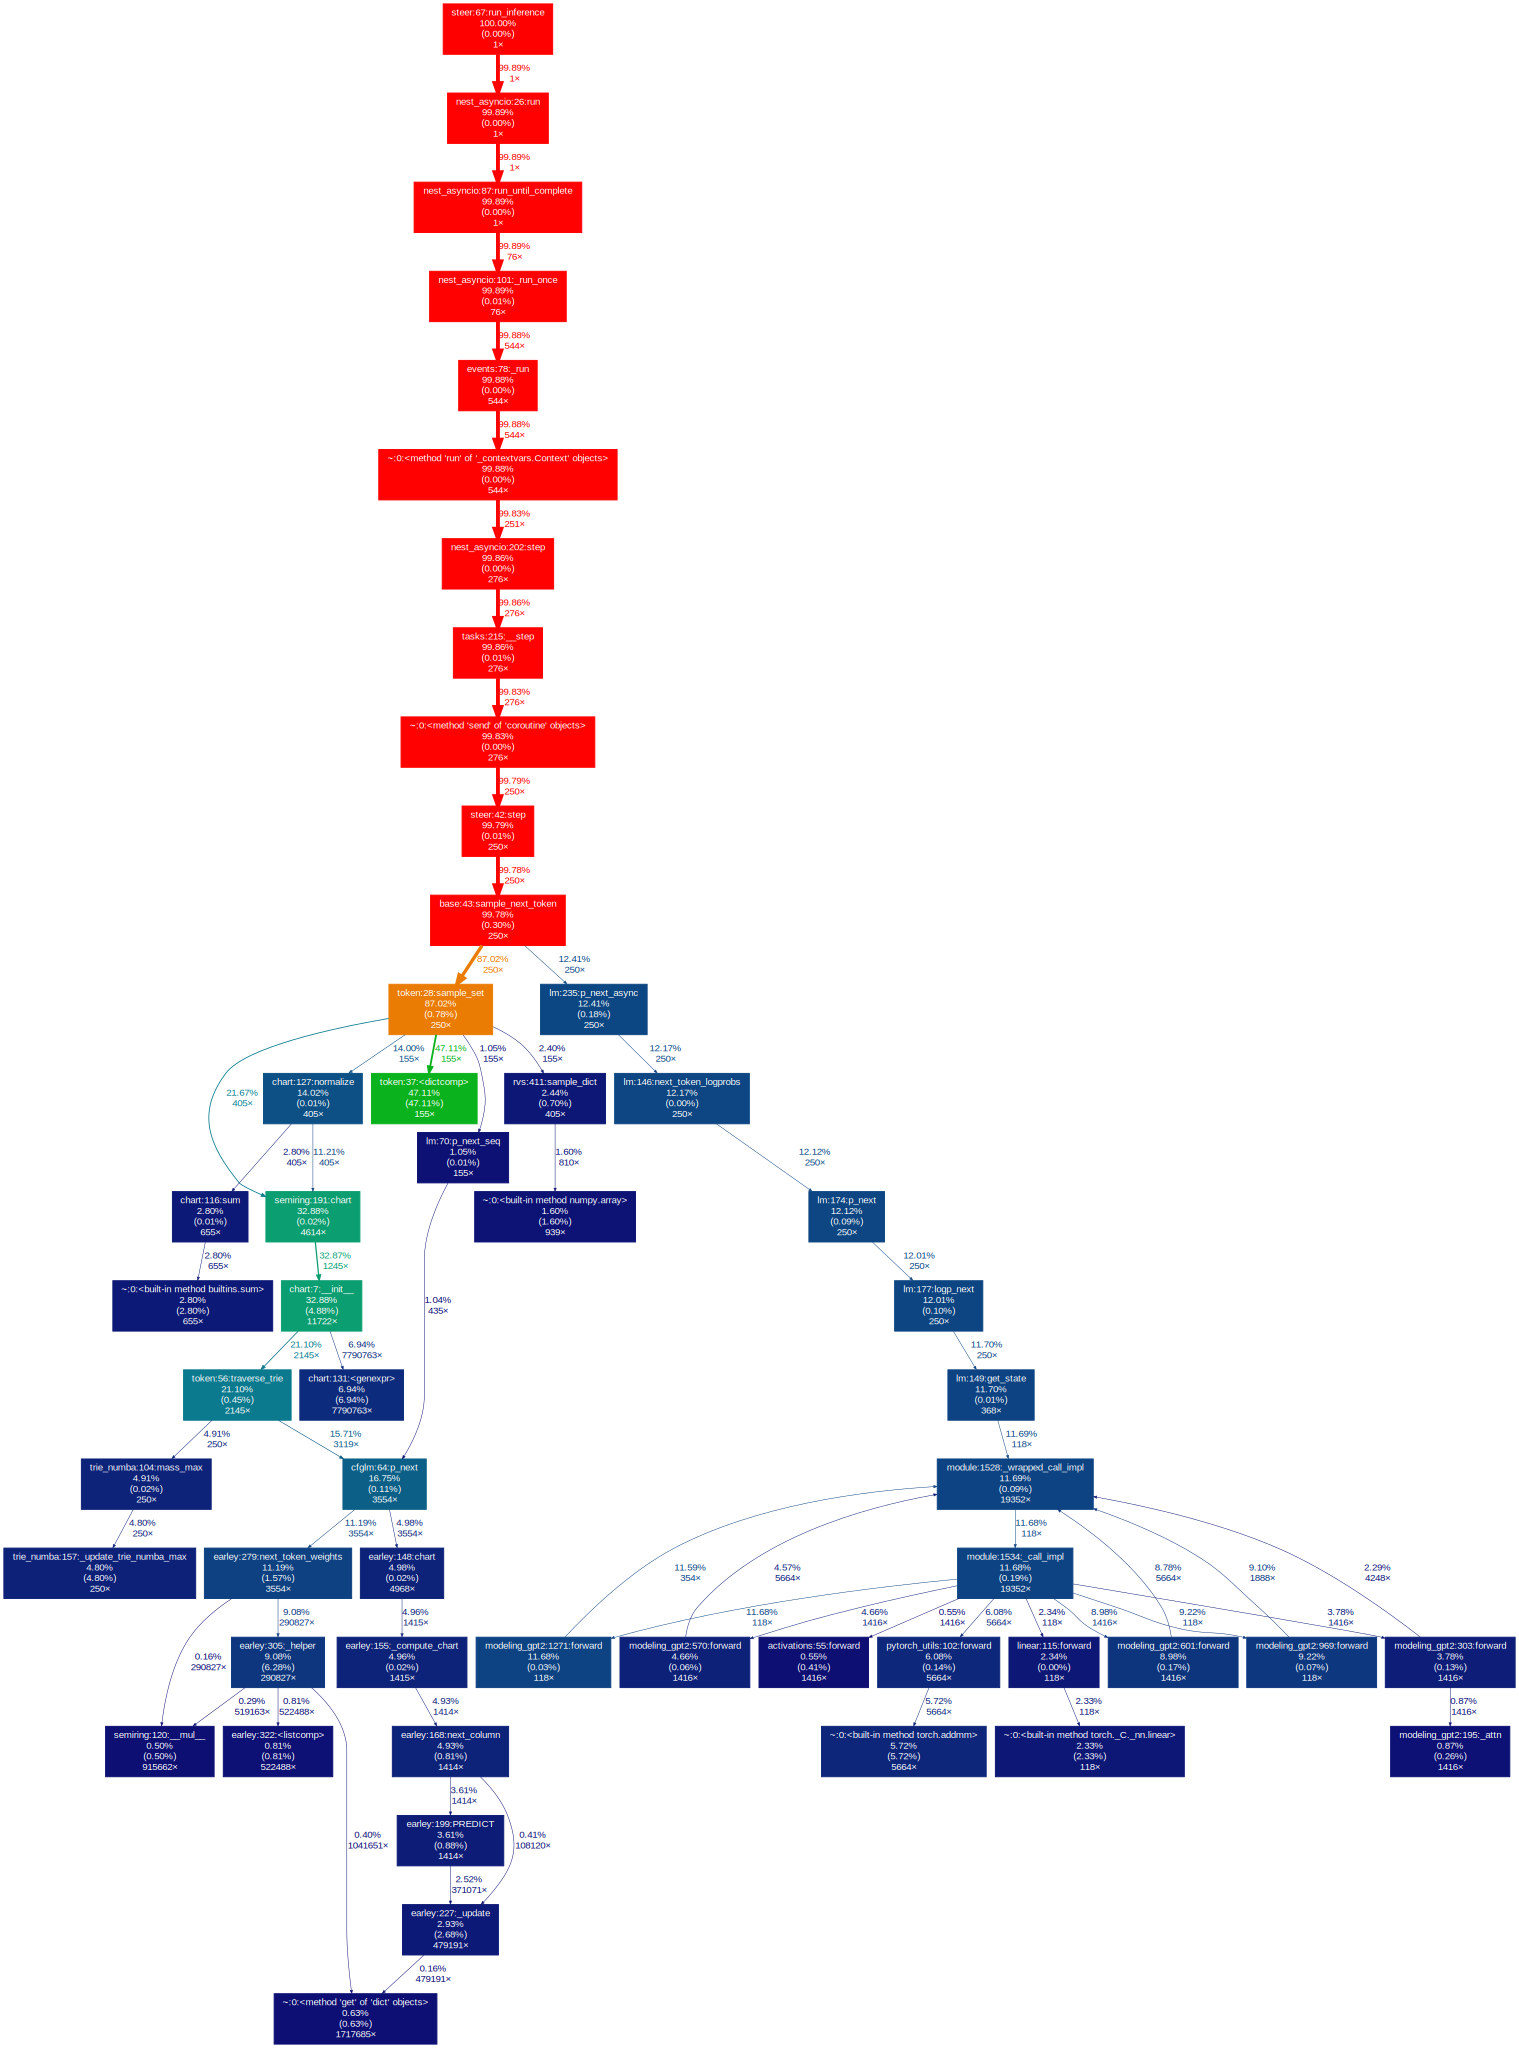

In [46]:
prof_to_graphviz('out.prof')